# Part 1: Synthetic Radar Signal Processing

## Objective
- Generate synthetic radar-like 1D and 2D signals mimicking range-Doppler readings.
- Create empty-room, metal-object, and clutter scenarios.
- Apply FFT-based transformations.
- Visualize range, doppler, and heatmaps.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fft2, fftshift
import random

# Configuration Parameters
c = 3e8  # Speed of light (m/s)
fc = 77e9  # Carrier frequency (77 GHz)
B = 4e9  # Bandwidth (4 GHz)
T_chirp = 60e-6  # Chirp duration (60 us)
slope = B / T_chirp
fs = 10e6  # Sampling frequency (10 MHz)
N_samples = int(T_chirp * fs)
N_chirps = 128  # Number of chirps per frame

print(f"Samples per chirp: {N_samples}")
print(f"Number of chirps: {N_chirps}")

Samples per chirp: 600
Number of chirps: 128


## 1. Signal Generation Functions

We will simulate the IF (Intermediate Frequency) signal, which is the result of mixing the transmitted FMCW chirp with the received echo.

The IF frequency $f_{IF}$ is related to range $R$ by:
$f_{IF} = S \frac{2R}{c}$

The phase change across chirps is related to velocity $v$.

In [3]:
def generate_radar_cube(num_chirps, num_samples, targets, noise_level=0.1):
    """
    Generates a radar data cube (Slow Time x Fast Time).
    
    Args:
        num_chirps: Number of chirps (slow time dimension).
        num_samples: Number of samples per chirp (fast time dimension).
        targets: List of dictionaries, each containing 'range', 'velocity', 'rcs'.
        noise_level: Amplitude of Gaussian noise.
        
    Returns:
        radar_cube: 2D numpy array (num_chirps x num_samples).
    """
    t = np.linspace(0, T_chirp, num_samples)
    radar_cube = np.zeros((num_chirps, num_samples), dtype=complex)
    
    # Generate signal for each target
    for target in targets:
        r0 = target['range']
        v = target['velocity']
        amp = target['rcs']  # Radar Cross Section amplitude factor
        
        for chirp_idx in range(num_chirps):
            # Update range for moving target (slow time evolution)
            # Time at start of this chirp
            t_c = chirp_idx * T_chirp 
            r_t = r0 + v * t_c
            
            # Beat frequency due to range
            fb = slope * 2 * r_t / c
            
            # Doppler frequency shift
            fd = 2 * v * fc / c
            
            # Phase shift due to range and doppler
            # The IF signal phase: 2*pi * (fb * t + fd * t_c + 2*fc*r_t/c)
            # Simplified model for IF signal:
            # S_if(t, chirp) = A * exp(j * 2*pi * (fb * t + fd * t_c))
            
            phase_fast = 2 * np.pi * fb * t
            phase_slow = 2 * np.pi * fd * t_c
            
            signal = amp * np.exp(1j * (phase_fast + phase_slow))
            radar_cube[chirp_idx, :] += signal
            
    # Add Gaussian Noise
    noise = noise_level * (np.random.randn(num_chirps, num_samples) + 1j * np.random.randn(num_chirps, num_samples))
    radar_cube += noise
    
    return radar_cube


## 2. Scenario Simulation

We will define three scenarios:
1. **Empty Room**: Only noise.
2. **Metal Object**: Strong reflection (high RCS), stationary or moving.
3. **Clutter**: Multiple random weak scatterers.

In [4]:
def get_scenario(scenario_type):
    targets = []
    if scenario_type == 'empty':
        # No targets, just noise (handled in generation function)
        pass
    elif scenario_type == 'metal':
        # Single strong target
        targets.append({'range': 10.0, 'velocity': 0.0, 'rcs': 5.0})
    elif scenario_type == 'clutter':
        # Multiple weak random targets
        for _ in range(10):
            r = np.random.uniform(1, 20)
            v = np.random.uniform(-2, 2)
            rcs = np.random.uniform(0.1, 0.5)
            targets.append({'range': r, 'velocity': v, 'rcs': rcs})
    elif scenario_type == 'metal_in_clutter':
        # Strong target + clutter
        targets.append({'range': 10.0, 'velocity': 0.0, 'rcs': 5.0})
        for _ in range(10):
            r = np.random.uniform(1, 20)
            v = np.random.uniform(-2, 2)
            rcs = np.random.uniform(0.1, 0.5)
            targets.append({'range': r, 'velocity': v, 'rcs': rcs})
            
    return targets

## 3. Processing and Visualization

We will apply Range FFT and Doppler FFT to generate the Range-Doppler Map (Heatmap).

Simulating Scenario: empty


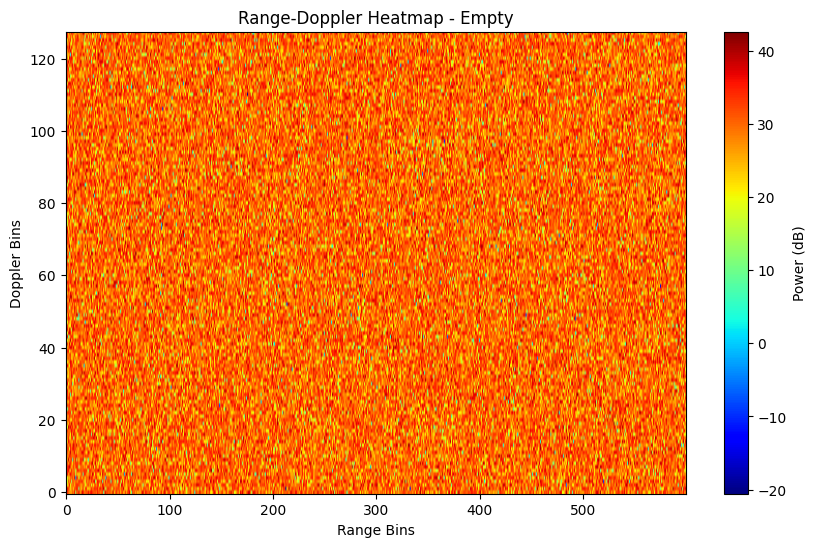

Simulating Scenario: metal


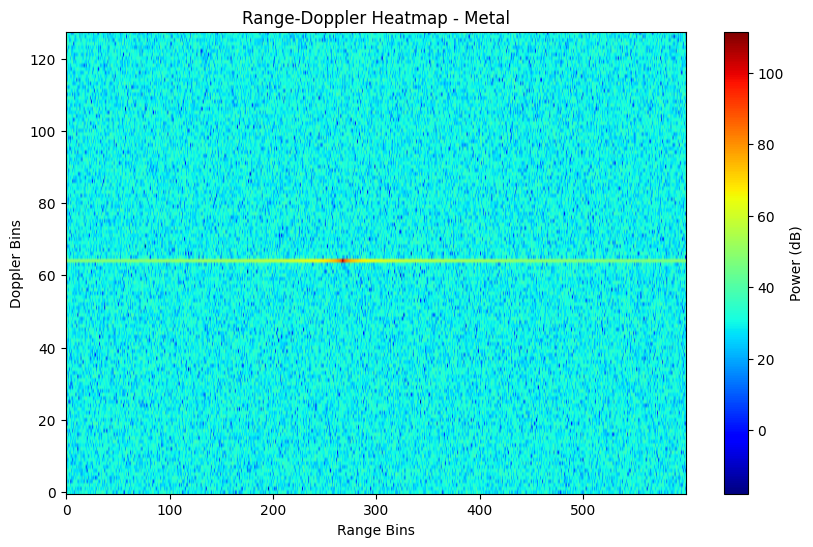

Simulating Scenario: clutter


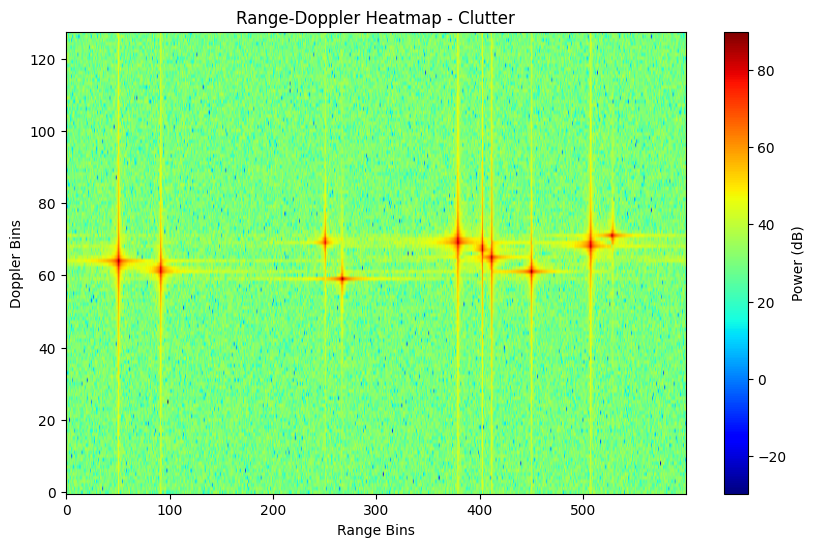

In [5]:
def process_radar_cube(radar_cube):
    # Range FFT (along fast time)
    range_fft = fft(radar_cube, axis=1)
    
    # Doppler FFT (along slow time)
    # We usually remove the first few bins or DC component if needed, but here we keep it simple
    range_doppler = fftshift(fft2(radar_cube), axes=0)
    
    return range_doppler

def plot_heatmap(range_doppler, title="Range-Doppler Heatmap"):
    # Log magnitude for visualization
    mag = 20 * np.log10(np.abs(range_doppler) + 1e-9)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(mag, aspect='auto', cmap='jet', origin='lower')
    plt.title(title)
    plt.xlabel('Range Bins')
    plt.ylabel('Doppler Bins')
    plt.colorbar(label='Power (dB)')
    plt.show()

# Test Scenarios
scenarios = ['empty', 'metal', 'clutter']

for s in scenarios:
    print(f"Simulating Scenario: {s}")
    targets = get_scenario(s)
    cube = generate_radar_cube(N_chirps, N_samples, targets)
    rd_map = process_radar_cube(cube)
    plot_heatmap(rd_map, title=f"Range-Doppler Heatmap - {s.capitalize()}")